In [1]:
%pylab inline

import numpy as np

from PIL import Image

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Populating the interactive namespace from numpy and matplotlib


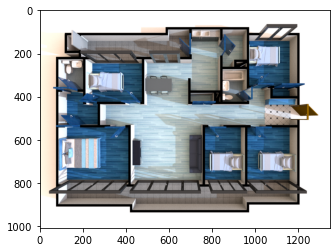

In [2]:
img_path = 'img/zigbang.png'
img = cv2.imread(img_path) #, cv2.IMREAD_COLOR)  #,cv2.COLOR_BGR2RGB )
plt.imshow(img)

In [22]:
img = cv2.imread(img_path) 
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

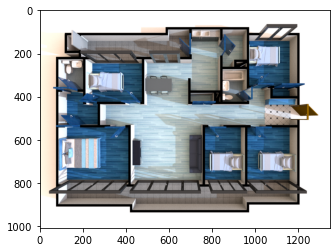

In [25]:
# Read image as gray-scale
img_org = cv2.imread(img_path, cv2.IMREAD_COLOR)
# Convert to gray-scale
img_gray = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
# Blur the image to reduce noise
img_blur = cv2.medianBlur(img_gray, 5)
# Apply hough transform on the image
plt.imshow(img_org)

In [26]:
# Apply hough transform on the image
circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=30)
# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw outer circle
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw inner circle
        cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)


In [27]:
template = cv2.imread('img/src3.png')
template = cv2.cvtColor(template, cv2.IMREAD_GRAYSCALE) 

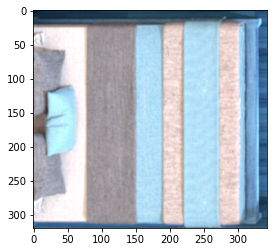

In [28]:
plt.imshow(template)

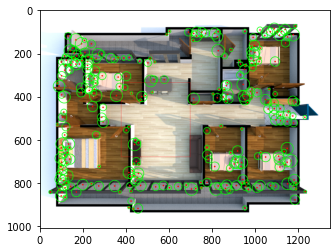

In [29]:
result = cv2.matchTemplate(img , template, cv2.TM_CCOEFF_NORMED)

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(result)
x, y = minLoc
w, h = template.shape[:2]


startX, startY = maxLoc # 만약 cv.TM_SQDIFF 혹은 cv.TM_SQDIFF_NORMED를 사용했을경우 최솟값을 사용해야한다.
endX, endY = startX + w, startY + h
output = cv2.rectangle(img, (startX, startY), (endX, endY), (0,0,255), 1)

image_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

#cv2.imwrite('result.png', img)


img = Image.open(img_path).resize((200, 150)).rotate(45)
img

In [30]:
# 권총을 평균 해시로 변환 (avg_hash.py)

import cv2

#영상 읽어서 그레이 스케일로 변환
#img = cv2.imread('../img/pistol.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 8x8 크기로 축소 ---①
gray = cv2.resize(gray, (16,16))
# 영상의 평균값 구하기 ---②
avg = gray.mean()
# 평균값을 기준으로 0과 1로 변환 ---③
bin = 1 * (gray > avg)
print(bin)

# 2진수 문자열을 16진수 문자열로 변환 ---④
dhash = []
for row in bin.tolist():
    s = ''.join([str(i) for i in row])
    dhash.append('%02x'%(int(s,2)))
dhash = ''.join(dhash)
print(dhash)


[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1]
 [1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1]
 [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1]
 [1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1]
 [1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
ffffffe7a003808bc3a3980183239ffd8703e703a303e30b80038003f80fffff


In [34]:
# 사물 이미지 중에서 권총 이미지 찾기 (avg_hash_matching.py)

import cv2
import numpy as np
import glob

# 영상 읽기 및 표시
#img = cv2.imread('../img/pistol.jpg')
cv2.imshow('query', img)

# 비교할 영상들이 있는 경로 ---①
search_dir = '/Users/reejungkim/Documents/Git/ImgProcessor/img/src3'

# 이미지를 16x16 크기의 평균 해쉬로 변환 ---②
def img2hash(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (16, 16))
    avg = gray.mean()
    bi = 1 * (gray > avg)
    return bi

# 해밍거리 측정 함수 ---③
def hamming_distance(a, b):
    a = a.reshape(1,-1)
    b = b.reshape(1,-1)
    # 같은 자리의 값이 서로 다른 것들의 합
    distance = (a !=b).sum()
    return distance

# 권총 영상의 해쉬 구하기 ---④
query_hash = img2hash(img)

# 이미지 데이타 셋 디렉토리의 모든 영상 파일 경로 ---⑤
img_path = glob.glob(search_dir+'/**/*.png')
for path in img_path:
    # 데이타 셋 영상 한개 읽어서 표시 ---⑥
    img = cv2.imread(path)
    cv2.imshow('searching...', img)
    cv2.waitKey(5)
    # 데이타 셋 영상 한개의 해시  ---⑦
    a_hash = img2hash(img)
    # 해밍 거리 산출 ---⑧
    dst = hamming_distance(query_hash, a_hash)
    if dst/256 < 0.25: # 해밍거리 25% 이내만 출력 ---⑨
        print(path, dst/256)
        cv2.imshow(path, img)

In [36]:
# 템플릿 매칭으로 객체 위치 검출 (template_matching.py)

import cv2
import numpy as np

# 입력이미지와 템플릿 이미지 읽기
img = cv2.imread('img/zigbang.png')
template = cv2.imread('img/src3.png')
th, tw = template.shape[:2]
cv2.imshow('template', template)

# 3가지 매칭 메서드 순회
methods = ['cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR_NORMED', \
                                     'cv2.TM_SQDIFF_NORMED']
for i, method_name in enumerate(methods):
    img_draw = img.copy()
    method = eval(method_name)
    # 템플릿 매칭   ---①
    res = cv2.matchTemplate(img, template, method)
    # 최솟값, 최댓값과 그 좌표 구하기 ---②
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print(method_name, min_val, max_val, min_loc, max_loc)

    # TM_SQDIFF의 경우 최솟값이 좋은 매칭, 나머지는 그 반대 ---③
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
        match_val = min_val
    else:
        top_left = max_loc
        match_val = max_val
    # 매칭 좌표 구해서 사각형 표시   ---④      
    bottom_right = (top_left[0] + tw, top_left[1] + th)
    cv2.rectangle(img_draw, top_left, bottom_right, (0,0,255),2)
    # 매칭 포인트 표시 ---⑤
    cv2.putText(img_draw, str(match_val), top_left, \
                cv2.FONT_HERSHEY_PLAIN, 2,(0,255,0), 1, cv2.LINE_AA)
    cv2.imshow(method_name, img_draw)

cv2.TM_CCOEFF_NORMED -0.4608651399612427 0.2622828781604767 (894, 48) (619, 615)
cv2.TM_CCORR_NORMED 0.7305507659912109 0.9227949380874634 (897, 91) (360, 408)
cv2.TM_SQDIFF_NORMED 0.15475358068943024 0.750986635684967 (360, 408) (700, 511)


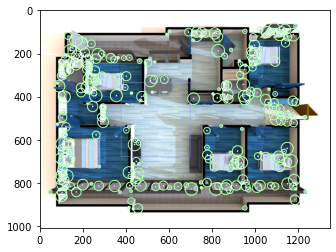

In [35]:
plt.imshow(img)

In [43]:

# 이미지 읽어오기
imgs = []
imgs.append(cv2.imread('img/zigbang.png'))
imgs.append(cv2.imread('img/src3.png'))

hists = []
for img in imgs:
    # BGR 이미지를 HSV 이미지로 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # 히스토그램 연산(파라미터 순서 : 이미지, 채널, Mask, 크기, 범위)
    hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    # 정규화(파라미터 순서 : 정규화 전 데이터, 정규화 후 데이터, 시작 범위, 끝 범위, 정규화 알고리즘)
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    # hists 리스트에 저장
    hists.append(hist)

# 1번째 이미지를 원본으로 지정
query = hists[0]

# 비교 알고리즘의 이름들을 리스트에 저장
methods = ['CORREL', 'CHISQR', 'INTERSECT', 'BHATTACHARYYA', 'EMD']

# 5회 반복(5개 비교 알고리즘을 모두 사용)
for index, name in enumerate(methods):
    # 비교 알고리즘 이름 출력(문자열 포맷팅 및 탭 적용)
    print('%-10s' % name, end = '\t')  
    
    # 2회 반복(2장의 이미지에 대해 비교 연산 적용)
    for i, histogram in enumerate(hists):
        ret = cv2.compareHist(query, histogram, index) 
        
        if index == cv2.HISTCMP_INTERSECT:                   #// 교차 분석인 경우 
            ret = ret/np.sum(query)                          #// 원본으로 나누어 1로 정규화
            
        print("img%d :%7.2f"% (i+1 , ret), end='\t')        #// 비교 결과 출력

    print()  

CORREL    	img1 :   1.00	img2 :   0.15	
CHISQR    	img1 :   0.00	img2 :118557.09	
INTERSECT 	img1 :   1.00	img2 :   0.47	
BHATTACHARYYA	img1 :   0.00	img2 :   0.80	
EMD       	img1 :   0.00	img2 : 111.65	
